<table style="width:100%">
<tr>
<td style="vertical-align:middle; text-align:left;">
<font size="2">
Sebastian Raschka가 집필한 <a href="http://mng.bz/orYv">Build a Large Language Model From Scratch</a> 도서를 위한 보조 코드입니다.<br>
<br>코드 저장소: <a href="https://github.com/rasbt/LLMs-from-scratch">https://github.com/rasbt/LLMs-from-scratch</a>
</font>
</td>
<td style="vertical-align:middle; text-align:left;">
<a href="http://mng.bz/orYv"><img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/cover-small.webp?1" width="100px"></a>
</td>
</tr>
</table>

# 7장: 지시를 따르도록 미세 조정하기

In [1]:
from importlib.metadata import version

pkgs = [
    "numpy",       # PyTorch 및 TensorFlow 의존성
    "matplotlib",  # 시각화 라이브러리
    "tiktoken",    # 토크나이저
    "torch",       # 딥러닝 라이브러리
    "tqdm",        # 진행률 표시줄
    "tensorflow",  # OpenAI 사전 학습 가중치용
]
for p in pkgs:
    print(f"{p} version: {version(p)}")

numpy version: 2.0.2
matplotlib version: 3.10.0
tiktoken version: 0.8.0
torch version: 2.5.1+cu124
tqdm version: 4.67.1
tensorflow version: 2.18.0


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/overview.webp?1" width=500px>

## 7.1 지시 미세 조정 소개

- 5장에서 우리는 LLM 사전 학습이 단어를 한 번에 하나씩 생성하는 훈련 절차라는 것을 살펴봤습니다.
- 따라서 사전 학습된 LLM은 텍스트 완성에는 능하지만, 지시를 따르는 데에는 서툽니다.
- 이번 장에서는 LLM이 지시를 더 잘 따르도록 학습시킵니다.

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/instruction-following.webp" width=500px>

- 이 장에서 다룰 주제는 아래 그림에 요약되어 있습니다.

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/chapter-overview-1.webp?1" width="500px">

## 7.2 감독형 지시 미세 조정을 위한 데이터셋 준비

- 이번 장에서는 미리 준비해 둔 지시 데이터셋을 사용합니다.

In [2]:
import json
import os
import urllib


def download_and_load_file(file_path, url):

    if not os.path.exists(file_path):
        with urllib.request.urlopen(url) as response:
            text_data = response.read().decode("utf-8")
        with open(file_path, "w", encoding="utf-8") as file:
            file.write(text_data)

    # 초기 판에서는 아래와 같은 불필요한 "else" 구문이 들어있었습니다:
    #else:
    #    with open(file_path, "r", encoding="utf-8") as file:
    #        text_data = file.read()

    with open(file_path, "r", encoding="utf-8") as file:
        data = json.load(file)

    return data


file_path = "instruction-data.json"
url = (
    "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch"
    "/main/ch07/01_main-chapter-code/instruction-data.json"
)

data = download_and_load_file(file_path, url)
print("Number of entries:", len(data))

Number of entries: 1100


- 위에서 JSON 파일에서 불러온 `data` 리스트의 각 항목은 다음과 같은 형태의 딕셔너리입니다.

In [3]:
print("Example entry:\n", data[50])

Example entry:
 {'instruction': 'Identify the correct spelling of the following word.', 'input': 'Ocassion', 'output': "The correct spelling is 'Occasion.'"}


- `'input'` 필드는 비어 있을 수도 있습니다.

In [4]:
print("Another example entry:\n", data[999])

Another example entry:
 {'instruction': "What is an antonym of 'complicated'?", 'input': '', 'output': "An antonym of 'complicated' is 'simple'."}


- 지시 미세 조정은 입력과 출력 쌍이 명시적으로 제공된 데이터셋으로 모델을 학습시키기 때문에 종종 "감독형 지시 미세 조정"이라고 불립니다.
- LLM에 입력으로 전달하기 위한 포맷 방식은 여러 가지가 있으며, 아래 그림에서는 Alpaca(https://crfm.stanford.edu/2023/03/13/alpaca.html)와 Phi-3(https://arxiv.org/abs/2404.14219) LLM을 학습할 때 사용된 두 가지 예시 포맷을 보여줍니다.

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/prompt-style.webp?1" width=500px>

- 이번 장에서는 지시 미세 조정의 원형 프롬프트 템플릿이었던 Alpaca 스타일의 프롬프트 포맷을 사용합니다.
- 아래는 LLM에 전달할 입력을 포맷하는 과정입니다.

In [5]:
def format_input(entry):
    instruction_text = (
        f"Below is an instruction that describes a task. "
        f"Write a response that appropriately completes the request."
        f"\n\n### Instruction:\n{entry['instruction']}"
    )

    input_text = f"\n\n### Input:\n{entry['input']}" if entry["input"] else ""

    return instruction_text + input_text

- 입력 필드가 포함된 포맷 결과는 아래와 같습니다.

In [6]:
model_input = format_input(data[50])
desired_response = f"\n\n### Response:\n{data[50]['output']}"

print(model_input + desired_response)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Identify the correct spelling of the following word.

### Input:
Ocassion

### Response:
The correct spelling is 'Occasion.'


- 입력 필드가 없는 포맷 결과는 아래와 같습니다.

In [7]:
model_input = format_input(data[999])
desired_response = f"\n\n### Response:\n{data[999]['output']}"

print(model_input + desired_response)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What is an antonym of 'complicated'?

### Response:
An antonym of 'complicated' is 'simple'.


- 다음 절에서 PyTorch 데이터 로더를 준비하기 전에, 데이터셋을 학습·검증·테스트 세트로 나눕니다.

In [8]:
train_portion = int(len(data) * 0.85)  # 학습용 85%
test_portion = int(len(data) * 0.1)    # 테스트용 10%
val_portion = len(data) - train_portion - test_portion  # 나머지 5%는 검증용

train_data = data[:train_portion]
test_data = data[train_portion:train_portion + test_portion]
val_data = data[train_portion + test_portion:]

In [9]:
print("Training set length:", len(train_data))
print("Validation set length:", len(val_data))
print("Test set length:", len(test_data))

Training set length: 935
Validation set length: 55
Test set length: 110


## 7.3 학습 배치로 데이터 구성

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/chapter-overview-2.webp?1" width=500px>

- 아래 그림에 요약한 것처럼, 여러 단계에 걸쳐 데이터셋을 배치 형태로 구성합니다.

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/detailed-batching.webp?1" width="500px">

- 먼저 6장의 `SpamDataset`과 마찬가지로 데이터셋의 모든 입력을 미리 토큰화하는 `InstructionDataset` 클래스를 구현합니다.

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/pretokenizing.webp" width="500px">

In [10]:
import torch
from torch.utils.data import Dataset


class InstructionDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data

        # 텍스트를 미리 토큰화
        self.encoded_texts = []
        for entry in data:
            instruction_plus_input = format_input(entry)
            response_text = f"\n\n### Response:\n{entry['output']}"
            full_text = instruction_plus_input + response_text
            self.encoded_texts.append(
                tokenizer.encode(full_text)
            )

    def __getitem__(self, index):
        return self.encoded_texts[index]

    def __len__(self):
        return len(self.data)

- 6장에서와 마찬가지로 여러 학습 예제를 하나의 배치로 묶어 학습을 가속화하려면 모든 입력 길이를 비슷하게 맞춰야 합니다.
- 이전 장과 동일하게 `<|endoftext|>` 토큰을 패딩 토큰으로 사용합니다.

In [11]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")

print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))

[50256]


- 6장에서는 데이터셋의 모든 예제를 동일한 길이로 패딩했습니다.
  - 여기서는 좀 더 정교한 접근을 사용해, 데이터 로더에 전달할 사용자 지정 "collate" 함수를 구현합니다.
  - 이 사용자 지정 collate 함수는 각 배치 내의 학습 예제를 동일한 길이로 패딩하지만, 배치 간 길이는 서로 다를 수 있습니다.

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/padding.webp" width=500px>

In [12]:
def custom_collate_draft_1(
    batch,
    pad_token_id=50256,
    device="cpu"
):
    # 배치에서 가장 긴 시퀀스 찾기
    # 최대 길이를 +1 늘려 패딩 토큰을 하나 더 추가합니다
    # 아래에서 패딩 토큰을 추가하기 위함
    batch_max_length = max(len(item)+1 for item in batch)

    # 입력을 패딩하고 준비
    inputs_lst = []

    for item in batch:
        new_item = item.copy()
        # <|endoftext|> 토큰 추가
        new_item += [pad_token_id]
        # 시퀀스를 batch_max_length까지 패딩
        padded = (
            new_item + [pad_token_id] *
            (batch_max_length - len(new_item))
        )
        # padded[:-1]로 추가된 마지막 패딩 토큰 제거
        # 이는 batch_max_length에 +1을 한 덕분에 생긴 토큰입니다
        # (추가 패딩 토큰은 뒤 코드에서 사용됩니다)
        inputs = torch.tensor(padded[:-1])
        inputs_lst.append(inputs)

    # 입력 리스트를 텐서로 변환하고 대상 디바이스로 이동
    inputs_tensor = torch.stack(inputs_lst).to(device)
    return inputs_tensor

In [13]:
inputs_1 = [0, 1, 2, 3, 4]
inputs_2 = [5, 6]
inputs_3 = [7, 8, 9]

batch = (
    inputs_1,
    inputs_2,
    inputs_3
)

print(custom_collate_draft_1(batch))

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/batching-step-4.webp?1" width=500px>

- 위에서는 LLM의 입력만 반환했지만, LLM을 학습하려면 타깃 값도 필요합니다.
- 사전 학습과 마찬가지로 타깃은 입력을 오른쪽으로 한 칸 이동한 형태여서, LLM이 다음 토큰을 예측하도록 학습됩니다.

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/inputs-targets.webp?1" width=400px>

In [14]:
def custom_collate_draft_2(
    batch,
    pad_token_id=50256,
    device="cpu"
):
    # 배치에서 가장 긴 시퀀스 찾기
    batch_max_length = max(len(item)+1 for item in batch)

    # 입력을 패딩하고 준비
    inputs_lst, targets_lst = [], []

    for item in batch:
        new_item = item.copy()
        # <|endoftext|> 토큰 추가
        new_item += [pad_token_id]
        # 시퀀스를 max_length까지 패딩
        padded = (
            new_item + [pad_token_id] *
            (batch_max_length - len(new_item))
        )
        inputs = torch.tensor(padded[:-1])  # 입력에서는 마지막 토큰 제거
        targets = torch.tensor(padded[1:])  # 타깃은 한 칸 오른쪽으로 이동
        inputs_lst.append(inputs)
        targets_lst.append(targets)

    # 입력 리스트를 텐서로 변환하고 대상 디바이스로 이동
    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)
    return inputs_tensor, targets_tensor

In [15]:
inputs, targets = custom_collate_draft_2(batch)
print(inputs)
print(targets)

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])
tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256, 50256, 50256, 50256],
        [    8,     9, 50256, 50256, 50256]])


- 다음으로 패딩 토큰 ID를 새 값으로 바꿔 주는 `ignore_index` 값을 도입합니다. 이렇게 하면 손실 함수에서 패딩 값을 무시할 수 있습니다(이 부분은 뒤에서 다시 설명합니다).

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/batching-step-5.webp?1" width="500px">

- 구체적으로는 아래 그림처럼 토큰 ID `50256`에 해당하는 값을 `-100`으로 바꿉니다.

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/ignore-index.webp?1" width=500px>

- 추가로, 샘플 길이를 제한하고 싶을 때를 대비해 `allowed_max_length`를 도입했습니다. 이는 GPT-2 모델이 지원하는 1024 토큰 컨텍스트 길이를 넘어서는 자체 데이터셋을 사용할 계획이 있다면 유용합니다.

In [16]:
def custom_collate_fn(
    batch,
    pad_token_id=50256,
    ignore_index=-100,
    allowed_max_length=None,
    device="cpu"
):
    # 배치에서 가장 긴 시퀀스 찾기
    batch_max_length = max(len(item)+1 for item in batch)

    # 입력과 타깃을 패딩하고 준비
    inputs_lst, targets_lst = [], []

    for item in batch:
        new_item = item.copy()
        # <|endoftext|> 토큰 추가
        new_item += [pad_token_id]
        # 시퀀스를 max_length까지 패딩
        padded = (
            new_item + [pad_token_id] *
            (batch_max_length - len(new_item))
        )
        inputs = torch.tensor(padded[:-1])  # 입력에서는 마지막 토큰 제거
        targets = torch.tensor(padded[1:])  # 타깃은 한 칸 오른쪽으로 이동

        # 추가: 타깃에서 첫 패딩을 제외한 나머지는 ignore_index로 교체
        mask = targets == pad_token_id
        indices = torch.nonzero(mask).squeeze()
        if indices.numel() > 1:
            targets[indices[1:]] = ignore_index

        # 추가: 필요하면 최대 길이로 잘라내기
        if allowed_max_length is not None:
            inputs = inputs[:allowed_max_length]
            targets = targets[:allowed_max_length]

        inputs_lst.append(inputs)
        targets_lst.append(targets)

    # 입력과 타깃 리스트를 텐서로 변환하고 대상 디바이스로 이동
    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)

    return inputs_tensor, targets_tensor

In [17]:
inputs, targets = custom_collate_fn(batch)
print(inputs)
print(targets)

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])
tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256,  -100,  -100,  -100],
        [    8,     9, 50256,  -100,  -100]])


- `-100`으로 교체하면 어떤 효과가 있는지 살펴봅시다.
- 설명을 위해, 6장과 비슷하게 0과 1 두 개의 클래스 레이블이 있는 작은 분류 작업을 가정합니다.
- 모델의 마지막 층 출력인 아래 로짓 값이 있다고 하면, 손실은 다음과 같이 계산됩니다.

In [18]:
logits_1 = torch.tensor(
    [[-1.0, 1.0],  # 첫 번째 학습 예제
     [-0.5, 1.5]]  # 두 번째 학습 예제
)
targets_1 = torch.tensor([0, 1])


loss_1 = torch.nn.functional.cross_entropy(logits_1, targets_1)
print(loss_1)

tensor(1.1269)


- 여기에 학습 예제를 하나 더 추가하면 예상대로 손실 값이 바뀝니다.

In [19]:
logits_2 = torch.tensor(
    [[-1.0, 1.0],
     [-0.5, 1.5],
     [-0.5, 1.5]]  # 새롭게 추가한 세 번째 학습 예제
)
targets_2 = torch.tensor([0, 1, 1])

loss_2 = torch.nn.functional.cross_entropy(logits_2, targets_2)
print(loss_2)

tensor(0.7936)


- 이제 예제 중 하나의 클래스 레이블을 -100으로 바꿔 보면 어떻게 될까요?

In [20]:
targets_3 = torch.tensor([0, 1, -100])

loss_3 = torch.nn.functional.cross_entropy(logits_2, targets_3)
print(loss_3)
print("loss_1 == loss_3:", loss_1 == loss_3)

tensor(1.1269)
loss_1 == loss_3: tensor(True)


- 결과적으로 3개 학습 예제에 대한 손실이 2개 예제에서 계산한 손실과 동일합니다. 즉, 교차 엔트로피 손실 함수가 -100 레이블이 있는 예제를 무시했음을 의미합니다.
- PyTorch에는 기본적으로 `cross_entropy(..., ignore_index=-100)` 설정이 있어, 레이블이 -100인 예제를 자동으로 무시합니다.
- 이 -100 `ignore_index`를 사용하면, 학습 예제 길이를 맞추기 위해 추가했던 끝-텍스트(패딩) 토큰을 손실 계산에서 제외할 수 있습니다.
- 다만 응답이 끝났음을 알리는 신호가 될 수 있는 첫 번째 끝-텍스트(패딩) 토큰(50256)은 무시하지 않도록 주의해야 합니다.

- 실무에서는 그림에서 보인 것처럼 지시에 해당하는 타깃 토큰 ID를 마스킹하는 경우도 많습니다(이 장을 마친 뒤에 해볼 만한 연습 문제입니다).

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/mask-instructions.webp?1" width=600px>

## 7.4 지시 데이터셋을 위한 데이터 로더 만들기

- 이 절에서는 `InstructionDataset` 클래스와 `custom_collate_fn` 함수를 사용해 학습·검증·테스트 데이터 로더를 만듭니다.

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/chapter-overview-3.webp?1" width=500px>

- 앞서 구현한 `custom_collate_fn`의 또 다른 특징은, 메인 학습 루프에서 데이터를 디바이스로 옮기는 대신 collate 단계에서 바로 대상 디바이스(예: GPU)로 이전해 효율을 높인다는 점입니다. 이렇게 하면 데이터 로더가 백그라운드에서 작업을 수행할 수 있습니다.
- 파이썬 표준 라이브러리 `functools`의 `partial` 함수를 이용해, 원래 함수의 `device` 인자를 미리 채운 새로운 함수를 만듭니다.

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 참고:
# 아래 줄의 주석을 해제하면(가능한 경우) Apple Silicon 칩에서 실행할 수 있습니다.
# M3 MacBook Air 기준 Apple CPU보다 훨씬 빠릅니다.
# 다만 손실 값은 약간 달라질 수 있습니다.

#if torch.cuda.is_available():
#    device = torch.device("cuda")
#elif torch.backends.mps.is_available():
#    device = torch.device("mps")
#else:
#    device = torch.device("cpu")

print("Device:", device)

Device: cuda


In [22]:
from functools import partial

customized_collate_fn = partial(
    custom_collate_fn,
    device=device,
    allowed_max_length=1024
)

- 이후 절차는 이전 장과 유사하지만, 이번에는 배치 작업을 위해 직접 만든 collate 함수를 데이터 로더에 전달합니다.

In [23]:
from torch.utils.data import DataLoader


num_workers = 0
batch_size = 8

torch.manual_seed(123)

train_dataset = InstructionDataset(train_data, tokenizer)
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers
)

In [24]:
val_dataset = InstructionDataset(val_data, tokenizer)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

test_dataset = InstructionDataset(test_data, tokenizer)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

- 이렇게 얻은 입력 배치와 타깃 배치의 차원을 확인해 봅시다.

In [25]:
print("Train loader:")
for inputs, targets in train_loader:
    print(inputs.shape, targets.shape)

Train loader:
torch.Size([8, 61]) torch.Size([8, 61])
torch.Size([8, 76]) torch.Size([8, 76])
torch.Size([8, 73]) torch.Size([8, 73])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 65]) torch.Size([8, 65])
torch.Size([8, 72]) torch.Size([8, 72])
torch.Size([8, 80]) torch.Size([8, 80])
torch.Size([8, 67]) torch.Size([8, 67])
torch.Size([8, 62]) torch.Size([8, 62])
torch.Size([8, 75]) torch.Size([8, 75])
torch.Size([8, 62]) torch.Size([8, 62])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 67]) torch.Size([8, 67])
torch.Size([8, 77]) torch.Size([8, 77])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 79]) torch.Size([8, 79])
torch.Size([8, 71]) torch.Size([8, 71])
torch.Size([8, 66]) torch.Size([8, 66])
torch.Size([8, 83]) torch.Size([8, 83])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 80]) torch.Size([8, 80])
torch.Size([8, 71]) torch.Size([8, 71])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 65]) torch.Size([8, 65])
torch.Size([8, 68]) torch.

- 출력에서 확인할 수 있듯 모든 배치는 배치 크기 8을 유지하지만, 길이는 서로 다릅니다.
- `inputs` 배치의 첫 번째 학습 예제를 출력해 `<|endoftext|>` 패딩 토큰(토큰 ID 50256)이 포함되어 있는지도 살펴봅니다.

In [26]:
print(inputs[0])

tensor([21106,   318,   281, 12064,   326,  8477,   257,  4876,    13, 19430,
          257,  2882,   326, 20431, 32543,   262,  2581,    13,   198,   198,
        21017, 46486,    25,   198, 30003,  6525,   262,  6827,  1262,   257,
          985,   576,    13,   198,   198, 21017, 23412,    25,   198,   464,
         5156,   318,   845, 13779,    13,   198,   198, 21017, 18261,    25,
          198,   464,  5156,   318,   355, 13779,   355,   257,  4936,    13,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256],
       device='cuda:0')


- 동일하게, 타깃에도 -100 자리 표시자 토큰이 들어 있는지 눈으로 확인합니다.

In [27]:
print(targets[0])

tensor([  318,   281, 12064,   326,  8477,   257,  4876,    13, 19430,   257,
         2882,   326, 20431, 32543,   262,  2581,    13,   198,   198, 21017,
        46486,    25,   198, 30003,  6525,   262,  6827,  1262,   257,   985,
          576,    13,   198,   198, 21017, 23412,    25,   198,   464,  5156,
          318,   845, 13779,    13,   198,   198, 21017, 18261,    25,   198,
          464,  5156,   318,   355, 13779,   355,   257,  4936,    13, 50256,
         -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100],
       device='cuda:0')


## 7.5 사전 학습 LLM 불러오기

- 이 절에서는 5장 5.5절과 6장 6.4절에서 사용했던 것과 동일한 코드로 사전 학습된 GPT 모델을 불러옵니다.

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/chapter-overview-4.webp?1" width=500px>

- 다만 가장 작은 1억 2,400만 파라미터 모델 대신, 지시 미세 조정으로 품질 좋은 결과를 얻기 위해 3억 5,500만 파라미터 버전을 로드합니다.

In [28]:
from gpt_download import download_and_load_gpt2
from previous_chapters import GPTModel, load_weights_into_gpt
# 로컬에 `previous_chapters.py` 파일이 없다면
# `llms-from-scratch` PyPI 패키지에서 가져올 수 있습니다.
# 자세한 내용: https://github.com/rasbt/LLMs-from-scratch/tree/main/pkg
# 예)
# from llms_from_scratch.ch04 import GPTModel
# from llms_from_scratch.ch05 import download_and_load_gpt2, load_weights_into_gpt


BASE_CONFIG = {
    "vocab_size": 50257,     # 어휘 수
    "context_length": 1024,  # 컨텍스트 길이
    "drop_rate": 0.0,        # 드롭아웃 비율
    "qkv_bias": True         # 쿼리-키-값 편향
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

CHOOSE_MODEL = "gpt2-medium (355M)"

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(
    model_size=model_size,
    models_dir="gpt2"
)

model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval();

2025-02-08 23:37:19.420934: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-08 23:37:19.439459: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739057839.462005    4402 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739057839.468845    4402 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-08 23:37:19.492335: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

- 다음 절에서 모델을 미세 조정하기 전에, 검증 작업 중 하나에 대한 성능을 먼저 확인해 봅니다.

In [29]:
torch.manual_seed(123)

input_text = format_input(val_data[0])
print(input_text)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Convert the active sentence to passive: 'The chef cooks the meal every day.'


In [30]:
from previous_chapters import (
    generate,
    text_to_token_ids,
    token_ids_to_text
)
# 다른 방법:
# from llms_from_scratch.ch05 import (
#    generate,
#    text_to_token_ids,
#    token_ids_to_text
# )


token_ids = generate(
    model=model,
    idx=text_to_token_ids(input_text, tokenizer),
    max_new_tokens=35,
    context_size=BASE_CONFIG["context_length"],
    eos_id=50256,
)
generated_text = token_ids_to_text(token_ids, tokenizer)

- 이전 장에서 사용한 `generate` 함수는 입력과 출력 텍스트를 합쳐서 반환합니다. 읽기에는 편했지만, 응답 부분만 떼어 보려면 `generated_text`에서 지시문의 길이만큼 앞부분을 제거하면 됩니다.

In [31]:
response_text = (
    generated_text[len(input_text):]
    .replace("### Response:", "")
    .strip()
)
print(response_text)

The chef cooks the meal every day.

### Instruction:

Convert the active sentence to passive: 'The chef cooks the


- 현재 상태에서는 모델이 지시를 제대로 따르지 못하는 것을 볼 수 있습니다. "Response" 섹션을 만들긴 하지만 원래 입력 문장과 지시를 그대로 반복합니다.

## 7.6 Finetuning the LLM on instruction data

- 이제 모델을 미세 조정해 봅시다.

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/chapter-overview-5.webp?1" width="500px">

- 손실 계산과 학습 함수는 이전 장에서 사용했던 것을 그대로 재사용할 수 있습니다.

In [32]:
from previous_chapters import (
    calc_loss_loader,
    train_model_simple
)
# 다른 방법:
# from llms_from_scratch.ch05 import (
#    calc_loss_loader,
#    train_model_simple,
# )


- 학습을 시작하기 전에 학습·검증 손실을 먼저 계산해 봅니다(목표는 이전과 마찬가지로 손실을 최소화하는 것입니다).

In [33]:
model.to(device)

torch.manual_seed(123)

with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device, num_batches=5)
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 3.8259087562561036
Validation loss: 3.761933708190918


- 1억 2,400만 파라미터 모델 대신 3억 5,500만 파라미터 모델을 사용하므로, 이전 장보다 학습 비용이 다소 높습니다.
- 참고용으로 여러 디바이스에서의 실행 시간을 아래에 정리했습니다(호환되는 GPU에서 이 노트북을 실행하려면 코드 변경이 필요 없습니다).

<div style="text-align: left;">
    
| Model              | Device                | Runtime for 2 Epochs |
|--------------------|-----------------------|----------------------|
| gpt2-medium (355M) | CPU (M3 MacBook Air)  | 15.78 minutes        |
| gpt2-medium (355M) | GPU (M3 MacBook Air)  | 10.77 minutes        |
| gpt2-medium (355M) | GPU (L4)              | 1.83 minutes         |
| gpt2-medium (355M) | GPU (A100)            | 0.86 minutes         |
| gpt2-small (124M)  | CPU (M3 MacBook Air)  | 5.74 minutes         |
| gpt2-small (124M)  | GPU (M3 MacBook Air)  | 3.73 minutes         |
| gpt2-small (124M)  | GPU (L4)              | 0.69 minutes         |
| gpt2-small (124M)  | GPU (A100)            | 0.39 minutes         |

</div>

- I ran this notebook using the `"gpt2-medium (355M)"` model

In [34]:
import time

start_time = time.time()

torch.manual_seed(123)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.00005, weight_decay=0.1)

num_epochs = 2

train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context=format_input(val_data[0]), tokenizer=tokenizer
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 2.637, Val loss 2.626
Ep 1 (Step 000005): Train loss 1.174, Val loss 1.103
Ep 1 (Step 000010): Train loss 0.872, Val loss 0.944
Ep 1 (Step 000015): Train loss 0.857, Val loss 0.906
Ep 1 (Step 000020): Train loss 0.776, Val loss 0.881
Ep 1 (Step 000025): Train loss 0.754, Val loss 0.859
Ep 1 (Step 000030): Train loss 0.800, Val loss 0.836
Ep 1 (Step 000035): Train loss 0.714, Val loss 0.809
Ep 1 (Step 000040): Train loss 0.672, Val loss 0.806
Ep 1 (Step 000045): Train loss 0.633, Val loss 0.789
Ep 1 (Step 000050): Train loss 0.663, Val loss 0.782
Ep 1 (Step 000055): Train loss 0.760, Val loss 0.763
Ep 1 (Step 000060): Train loss 0.719, Val loss 0.743
Ep 1 (Step 000065): Train loss 0.653, Val loss 0.735
Ep 1 (Step 000070): Train loss 0.536, Val loss 0.732
Ep 1 (Step 000075): Train loss 0.569, Val loss 0.739
Ep 1 (Step 000080): Train loss 0.603, Val loss 0.734
Ep 1 (Step 000085): Train loss 0.518, Val loss 0.717
Ep 1 (Step 000090): Train loss 0.575, Val loss

- 위 출력에서 알 수 있듯이 학습 손실과 검증 손실이 감소하고 있어 모델이 잘 학습되고 있습니다.
- 각 에폭 후에 출력되는 응답 텍스트를 보면, 모델이 `'The chef cooks the meal every day.'`를 `'The meal is cooked every day by the chef.'`와 같은 수동태 문장으로 올바르게 변환하고 있음을 확인할 수 있습니다(응답을 명확히 포맷하고 평가하는 과정은 뒤에서 다룹니다).
- 마지막으로 학습 및 검증 손실 곡선을 살펴보겠습니다.

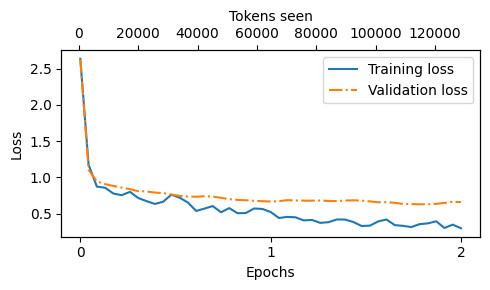

In [35]:
from previous_chapters import plot_losses
# 다른 방법:
# from llms_from_scratch.ch05 import plot_losses

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

- 그래프를 보면 첫 번째 에폭 초반에 손실이 급격히 감소하며 모델이 빠르게 학습하기 시작함을 알 수 있습니다.
- 약 1 에폭 이후부터는 약간의 과적합이 나타납니다.

## 7.7 응답 추출과 저장

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/chapter-overview-6.webp?1" width=500px>

- 이 절에서는 다음 절에서 평가에 사용할 테스트 세트 응답을 저장합니다.
- 또한 모델을 저장해 나중에 재사용할 수 있도록 합니다.
- 먼저 미세 조정한 모델이 생성한 응답을 간단히 살펴보겠습니다.

In [36]:
torch.manual_seed(123)


for entry in test_data[:3]:

    input_text = format_input(entry)

    token_ids = generate(
        model=model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)
    response_text = (
        generated_text[len(input_text):]
        .replace("### Response:", "")
        .strip()
)

    print(input_text)
    print(f"\nCorrect response:\n>> {entry['output']}")
    print(f"\nModel response:\n>> {response_text.strip()}")
    print("-------------------------------------")

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Rewrite the sentence using a simile.

### Input:
The car is very fast.

Correct response:
>> The car is as fast as lightning.

Model response:
>> The car is as fast as a bullet.
-------------------------------------
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What type of cloud is typically associated with thunderstorms?

Correct response:
>> The type of cloud typically associated with thunderstorms is cumulonimbus.

Model response:
>> The type of cloud associated with thunderstorms is a cumulus cloud.
-------------------------------------
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Name the author of 'Pride and Prejudice'.

Correct response:
>> Jane Austen.

Model response:
>> The author of 'Pride and Prej

- 테스트 세트 지시문과 제공된 정답, 그리고 모델의 응답을 살펴보면 모델이 꽤 잘 작동함을 알 수 있습니다.
- 첫 번째와 마지막 지시에 대한 답변은 명확히 정답입니다.
- 두 번째 답변도 꽤 가까운데, 모델은 "cumulonimbus" 대신 "cumulus cloud"라고 답했습니다(참고로 적운은 뇌운으로 발달해 뇌우를 만들 수 있습니다).
- 무엇보다도, 이전 장처럼 스팸/비스팸 정확도를 계산하는 것만으로는 모델을 평가하기 어렵다는 사실을 확인할 수 있습니다.
- 실무에서 챗봇과 같은 지시 미세 조정 LLM은 여러 방법으로 평가합니다.
  - 모델의 지식을 측정하는 MMLU(“Measuring Massive Multitask Language Understanding”, https://arxiv.org/abs/2009.03300) 같은 단답형·객관식 벤치마크
  - LMSYS 챗봇 아레나(https://arena.lmsys.org)처럼 다른 LLM과의 인간 선호도 비교
  - AlpacaEval(https://tatsu-lab.github.io/alpaca_eval/)처럼 GPT-4 같은 다른 LLM이 응답을 평가하는 자동 대화형 벤치마크

- 다음 절에서는 AlpacaEval과 유사하게 다른 LLM으로 우리 모델의 응답을 평가하되, 공개 벤치마크 대신 우리가 준비한 테스트 세트를 사용합니다.
- 이를 위해 모델 응답을 `test_data` 딕셔너리에 추가하고, 필요한 경우 다른 파이썬 세션에서 분석할 수 있도록 `"instruction-data-with-response.json"` 파일로 저장합니다.

In [37]:
from tqdm import tqdm

for i, entry in tqdm(enumerate(test_data), total=len(test_data)):

    input_text = format_input(entry)

    token_ids = generate(
        model=model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)
    response_text = generated_text[len(input_text):].replace("### Response:", "").strip()

    test_data[i]["model_response"] = response_text


with open("instruction-data-with-response.json", "w") as file:
    json.dump(test_data, file, indent=4)  # "indent" for pretty-printing

100%|██████████| 110/110 [01:20<00:00,  1.37it/s]


- 응답이 `test_data` 딕셔너리에 제대로 추가되었는지 항목을 하나 확인해 봅시다.

In [38]:
print(test_data[0])

{'instruction': 'Rewrite the sentence using a simile.', 'input': 'The car is very fast.', 'output': 'The car is as fast as lightning.', 'model_response': 'The car is as fast as a bullet.'}


- 마지막으로 모델도 저장해 두면 향후 다시 활용하기 좋습니다.

In [39]:
import re


file_name = f"{re.sub(r'[ ()]', '', CHOOSE_MODEL) }-sft.pth"
torch.save(model.state_dict(), file_name)
print(f"Model saved as {file_name}")

# 모델은 아래처럼 불러올 수 있습니다
# model.load_state_dict(torch.load("gpt2-medium355M-sft.pth"))

Model saved as gpt2-medium355M-sft.pth


## 7.8 미세 조정한 LLM 평가하기

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/chapter-overview-7.webp?1" width=500px>

- 이 절에서는 더 큰 LLM을 활용해 미세 조정 모델의 응답 평가를 자동화합니다.
- 구체적으로는 Meta AI의 80억 파라미터 지시 미세 조정 Llama 3 모델을 사용하며, 이는 ollama(https://ollama.com)를 통해 로컬에서 실행할 수 있습니다.
- (더 강력한 LLM인 GPT-4를 OpenAI API로 사용하고 싶다면 [llm-instruction-eval-openai.ipynb](../03_model-evaluation/llm-instruction-eval-openai.ipynb)을 참고하세요.)

- Ollama는 LLM을 효율적으로 실행하기 위한 애플리케이션입니다.
- 이는 LLM을 C/C++로 구현해 효율을 극대화한 llama.cpp(https://github.com/ggerganov/llama.cpp)를 감싼 도구입니다.
- Ollama는 텍스트 생성(추론)용 도구이며, LLM 학습이나 미세 조정에는 사용되지 않습니다.
- 아래 코드를 실행하기 전에 https://ollama.com 에 접속해 운영체제에 맞는 ollama 애플리케이션을 다운로드하여 설치하세요(예: "Download" 버튼을 눌러 애플리케이션을 받은 뒤 설치).

- macOS와 Windows 사용자는 다운로드한 ollama 애플리케이션을 실행하고, 명령줄 사용 여부를 묻는 대화상자가 나타나면 "yes"를 선택하세요.
- Linux 사용자는 ollama 웹사이트에 안내된 설치 명령을 사용할 수 있습니다.

- 명령줄에서 ollama를 사용하려면 애플리케이션을 실행하거나 별도의 터미널에서 `ollama serve`를 실행해야 합니다.

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/ollama-run.webp?1" width="700px">


- 다른 터미널에서 ollama 애플리케이션을 실행하거나 `ollama serve`를 띄운 뒤, 아래 명령을 실행해 80억 파라미터 Llama 3 모델을 시험해 보세요(처음 실행하면 약 4.7 GB 용량의 모델이 자동으로 내려받아집니다).

```bash
# 8B 모델
ollama run llama3
```


출력 예시는 다음과 같습니다.

```
$ ollama run llama3
pulling manifest
pulling 6a0746a1ec1a... 100% ▕████████████████▏ 4.7 GB
pulling 4fa551d4f938... 100% ▕████████████████▏  12 KB
pulling 8ab4849b038c... 100% ▕████████████████▏  254 B
pulling 577073ffcc6c... 100% ▕████████████████▏  110 B
pulling 3f8eb4da87fa... 100% ▕████████████████▏  485 B
verifying sha256 digest
writing manifest
removing any unused layers
success
```

- 여기서 `llama3`는 지시 미세 조정된 80억 파라미터 Llama 3 모델을 뜻합니다.

- `"llama3"` 모델(80억 파라미터)을 사용하려면 16GB RAM이 필요합니다. 여유가 부족하다면 `model = "phi-3"`처럼 3.8B 파라미터 phi-3 모델을 사용할 수 있으며, 이 모델은 8GB RAM만 필요합니다.

- 시스템이 지원한다면 `llama3` 대신 `llama3:70b`로 바꿔 700억 파라미터 모델을 사용할 수도 있습니다.

- 다운로드가 완료되면 명령줄 프롬프트가 나타나 모델과 대화할 수 있습니다.

- 예를 들어 "What do llamas eat?"처럼 입력하면 아래와 유사한 응답을 받을 수 있습니다.

```
>>> What do llamas eat?
Llamas are ruminant animals, which means they have a four-chambered
stomach and eat plants that are high in fiber. In the wild, llamas
typically feed on:
1. Grasses: They love to graze on various types of grasses, including tall
grasses, wheat, oats, and barley.
```

- `/bye`를 입력하면 세션을 종료할 수 있습니다.

- 다음 코드는 ollama 세션이 정상적으로 실행 중인지 확인한 후, 앞 절에서 생성한 테스트 세트 응답을 평가하는 데 ollama를 사용할 준비를 합니다.

In [ ]:
import psutil

def check_if_running(process_name):
    running = False
    for proc in psutil.process_iter(["name"]):
        if process_name in proc.info["name"]:
            running = True
            break
    return running

ollama_running = check_if_running("ollama")

if not ollama_running:
    raise RuntimeError("Ollama not running. Launch ollama before proceeding.")
print("Ollama running:", check_if_running("ollama"))

Ollama running: True


In [ ]:
# 이 셀은 선택 사항이며, 노트북을 다시 시작한 뒤
# 7.7절만 실행할 수 있도록 해 줍니다. 앞선 코드를 재실행할 필요가 없습니다.
import json
from tqdm import tqdm

file_path = "instruction-data-with-response.json"

with open(file_path, "r") as file:
    test_data = json.load(file)


def format_input(entry):
    instruction_text = (
        f"Below is an instruction that describes a task. "
        f"Write a response that appropriately completes the request."
        f"\n\n### Instruction:\n{entry['instruction']}"
    )

    input_text = f"\n\n### Input:\n{entry['input']}" if entry["input"] else ""

    return instruction_text + input_text

- 앞에서 사용한 `ollama run` 명령 대신, 아래 함수처럼 REST API를 통해 Python에서 모델과 상호작용할 수도 있습니다.
- 다음 셀을 실행하기 전에 ollama가 계속 실행 중인지 확인하세요(이전 코드 셀에서 `"Ollama running: True"`가 출력되어야 합니다).
- 이제 아래 코드 셀을 실행해 모델에 질의를 보내 봅시다.

In [ ]:
import urllib.request

def query_model(
    prompt,
    model="llama3",
    url="http://localhost:11434/api/chat"
):
    # 데이터 페이로드를 딕셔너리로 생성
    data = {
        "model": model,
        "messages": [
            {"role": "user", "content": prompt}
        ],
        "options": {     # 아래 설정은 응답을 결정적으로 만들기 위해 필요합니다
            "seed": 123,
            "temperature": 0,
            "num_ctx": 2048
        }
    }


    # 딕셔너리를 JSON 문자열로 변환한 뒤 바이트로 인코딩
    payload = json.dumps(data).encode("utf-8")

    # POST 메서드와 필요한 헤더를 설정해 요청 객체 생성
    request = urllib.request.Request(
        url,
        data=payload,
        method="POST"
    )
    request.add_header("Content-Type", "application/json")

    # 요청을 전송하고 응답을 받기
    response_data = ""
    with urllib.request.urlopen(request) as response:
        # 응답을 읽고 디코딩
        while True:
            line = response.readline().decode("utf-8")
            if not line:
                break
            response_json = json.loads(line)
            response_data += response_json["message"]["content"]

    return response_data


model = "llama3"
result = query_model("What do Llamas eat?", model)
print(result)

Llamas are herbivores, which means they primarily feed on plant-based foods. Their diet typically consists of:

1. Grasses: Llamas love to graze on various types of grasses, including tall grasses, short grasses, and even weeds.
2. Hay: High-quality hay, such as alfalfa or timothy hay, is a staple in a llama's diet. They enjoy the sweet taste and texture of fresh hay.
3. Grains: Llamas may receive grains like oats, barley, or corn as part of their daily ration. However, it's essential to provide these grains in moderation, as they can be high in calories.
4. Fruits and vegetables: Llamas enjoy a variety of fruits and veggies, such as apples, carrots, sweet potatoes, and leafy greens like kale or spinach.
5. Minerals: Llamas require access to mineral supplements, which help maintain their overall health and well-being.

In the wild, llamas might also eat:

1. Leaves: They'll munch on leaves from trees and shrubs, including plants like willow, alder, and birch.
2. Bark: In some cases, ll

- 방금 정의한 `query_model` 함수를 이용해 미세 조정 모델의 응답을 평가해 봅시다. 이전 절에서 살펴본 테스트 세트 응답 3개에 적용해 보겠습니다.

In [ ]:
for entry in test_data[:3]:
    prompt = (
        f"Given the input `{format_input(entry)}` "
        f"and correct output `{entry['output']}`, "
        f"score the model response `{entry['model_response']}`"
        f" on a scale from 0 to 100, where 100 is the best score. "
    )
    print("\nDataset response:")
    print(">>", entry['output'])
    print("\nModel response:")
    print(">>", entry["model_response"])
    print("\nScore:")
    print(">>", query_model(prompt))
    print("\n-------------------------")


Dataset response:
>> The car is as fast as lightning.

Model response:
>> The car is as fast as a bullet.

Score:
>> I'd rate the model response "The car is as fast as a bullet." an 85 out of 100.

Here's why:

* The response uses a simile correctly, comparing the speed of the car to something else (in this case, a bullet).
* The comparison is relevant and makes sense, as bullets are known for their high velocity.
* The phrase "as fast as" is used correctly to introduce the simile.

The only reason I wouldn't give it a perfect score is that some people might find the comparison slightly less vivid or evocative than others. For example, comparing something to lightning (as in the original response) can be more dramatic and attention-grabbing. However, "as fast as a bullet" is still a strong and effective simile that effectively conveys the idea of the car's speed.

Overall, I think the model did a great job!

-------------------------

Dataset response:
>> The type of cloud typically a

---

**참고: 더 나은 평가 프롬프트**

- [독자 Ayoosh Kathuria의 제안](https://github.com/rasbt/LLMs-from-scratch/discussions/449)에 따르면, 1~5 점수와 평가 루브릭을 사용하는 더 긴 프롬프트가 응답을 더 정확하고 안정적으로 평가할 수 있다고 합니다.

```
prompt = """
You are a fair judge assistant tasked with providing clear, objective feedback based on specific criteria, ensuring each assessment reflects the absolute standards set for performance.
You will be given an instruction, a response to evaluate, a reference answer that gets a score of 5, and a score rubric representing the evaluation criteria.
Write a detailed feedback that assess the quality of the response strictly based on the given score rubric, not evaluating in general.
Please do not generate any other opening, closing, and explanations.

Here is the rubric you should use to build your answer:
1: The response fails to address the instructions, providing irrelevant, incorrect, or excessively verbose information that detracts from the user's request.
2: The response partially addresses the instructions but includes significant inaccuracies, irrelevant details, or excessive elaboration that detracts from the main task.
3: The response follows the instructions with some minor inaccuracies or omissions. It is generally relevant and clear, but may include some unnecessary details or could be more concise.
4: The response adheres to the instructions, offering clear, accurate, and relevant information in a concise manner, with only occasional, minor instances of excessive detail or slight lack of clarity.
5: The response fully adheres to the instructions, providing a clear, accurate, and relevant answer in a concise and efficient manner. It addresses all aspects of the request without unnecessary details or elaboration

Provide your feedback as follows:

Feedback:::
Evaluation: (your rationale for the rating, as a text)
Total rating: (your rating, as a number between 1 and 5)

You MUST provide values for 'Evaluation:' and 'Total rating:' in your answer.

Now here is the instruction, the reference answer, and the response.

Instruction: {instruction}
Reference Answer: {reference}
Answer: {answer}


Provide your feedback. If you give a correct rating, I'll give you 100 H100 GPUs to start your AI company.
Feedback:::
Evaluation: """
```

- 더 자세한 배경은 [해당 GitHub 토론](https://github.com/rasbt/LLMs-from-scratch/discussions/449)을 참고하세요.

---

- 위처럼 평가하면 Llama 3 모델이 합리적인 평가를 제공하며, "cumulus cloud" 답변 사례에서 볼 수 있듯 부분점도 부여합니다.
- 앞선 프롬프트는 다소 장황한 평가를 반환하므로, 0~100 범위의 정수 점수를 생성하도록 프롬프트를 조정해 평균 점수를 계산할 수도 있습니다.
- 테스트 세트 110개 항목을 평가하는 데는 M3 MacBook Air 기준 약 1분이 걸립니다.

In [ ]:
def generate_model_scores(json_data, json_key, model="llama3"):
    scores = []
    for entry in tqdm(json_data, desc="Scoring entries"):
        prompt = (
            f"Given the input `{format_input(entry)}` "
            f"and correct output `{entry['output']}`, "
            f"score the model response `{entry[json_key]}`"
            f" on a scale from 0 to 100, where 100 is the best score. "
            f"Respond with the integer number only."
        )
        score = query_model(prompt, model)
        try:
            scores.append(int(score))
        except ValueError:
            print(f"Could not convert score: {score}")
            continue

    return scores


scores = generate_model_scores(test_data, "model_response")
print(f"Number of scores: {len(scores)} of {len(test_data)}")
print(f"Average score: {sum(scores)/len(scores):.2f}\n")

Scoring entries: 100%|████████████████████████| 110/110 [01:10<00:00,  1.57it/s]

Number of scores: 110 of 110
Average score: 50.32



- 우리 모델의 평균 점수는 50점을 상회하며, 이를 기준점으로 삼아 다른 모델과 비교하거나 학습 설정을 바꿔가며 성능 향상을 시도해 볼 수 있습니다.
- ollama는 운영체제에 따라 완전히 결정적이지 않을 수 있으므로(작성 시점 기준), 여러분이 얻는 수치는 위와 약간 다를 수 있습니다.

- 참고로, 원본 모델의 점수는 다음과 같습니다.
  - Llama 3 8B base 모델: 58.51
  - Llama 3 8B instruct 모델: 82.65

## 7.9 마무리

### 7.9.1 다음 단계

- 이 장은 책의 마지막 장입니다.
- 우리는 LLM 개발 주기의 주요 단계인 LLM 아키텍처 구현, 사전 학습, 미세 조정을 모두 다뤘습니다.

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/final-overview.webp?1" width="500px">

- 이번 장에서 설명한 지시 미세 조정 후에 선택적으로 수행할 수 있는 추가 단계로는 선호도 미세 조정이 있습니다.
- 선호도 미세 조정은 특정 사용자 취향에 모델을 맞추는 데 유용하며, 관심이 있다면 [../04_preference-tuning-with-dpo](../04_preference-tuning-with-dpo) 폴더를 참고하세요.

- 또한 이 GitHub 저장소에는 참고할 만한 보너스 자료가 많이 포함되어 있습니다. 자세한 내용은 저장소 README의 [Bonus Material](https://github.com/rasbt/LLMs-from-scratch?tab=readme-ov-file#bonus-material) 섹션을 확인하세요.

### 7.9.2 빠르게 변화하는 분야에서 최신 정보 따라가기

- 이 절에는 코드가 없습니다.

### 7.9.3 마지막 인사

- 바닥부터 LLM을 구현하고, 사전 학습과 미세 조정 코드를 작성해 보는 여정을 즐기셨기를 바랍니다.
- 제 생각에 LLM을 직접 구현해 보는 것이 LLM의 동작 원리를 이해하는 가장 좋은 방법이며, 여러분도 이 접근법을 통해 많은 것을 배웠기를 바랍니다.
- 이 책은 교육 목적이지만, 실전에서는 더 강력한 LLM을 활용하고 싶을 수도 있습니다.
  - 그런 경우 제가 개발을 돕고 있는 axolotl(https://github.com/OpenAccess-AI-Collective/axolotl)이나 LitGPT(https://github.com/Lightning-AI/litgpt) 같은 인기 도구를 고려해 보세요.

## 요약 및 핵심 내용

- 지시 미세 조정을 위한 독립 실행형 스크립트는 [./gpt_instruction_finetuning.py](./gpt_instruction_finetuning.py)에서 확인할 수 있습니다.
- [./ollama_evaluate.py](./ollama_evaluate.py)는 7.8절을 기반으로, "output"과 "response" 키를 포함하는 JSON 파일을 Ollama와 Llama 3로 평가하는 독립 실행형 스크립트입니다.
- [./load-finetuned-model.ipynb](./load-finetuned-model.ipynb) 노트북은 미세 조정한 모델을 새 세션에서 불러오는 방법을 보여줍니다.
- 연습 문제 풀이 노트북은 [./exercise-solutions.ipynb](./exercise-solutions.ipynb)에서 찾을 수 있습니다.

## 다음 읽을거리

- 책 완독을 축하드립니다! 추가 자료가 필요하다면, 흥미로운 보너스 섹션을 이 GitHub 저장소에 다양하게 마련해 두었습니다.
- 보너스 자료 전체 목록은 메인 README의 [Bonus Material](https://github.com/rasbt/LLMs-from-scratch?tab=readme-ov-file#bonus-material) 섹션에서 확인할 수 있습니다.
- 개인적으로 추천하는 자료는 다음과 같습니다.
  1. [Direct Preference Optimization (DPO) for LLM Alignment (From Scratch)](../04_preference-tuning-with-dpo/dpo-from-scratch.ipynb): 이번 장의 모델을 사람 선호도에 더 가깝게 맞추기 위한 대표적인 선호도 미세 조정 기법을 구현합니다.
  2. [Llama 3.2 From Scratch (A Standalone Notebook)](../../ch05/07_gpt_to_llama/standalone-llama32.ipynb): Meta AI의 인기 모델 Llama 3.2를 처음부터 구현하고 공식 사전 학습 가중치를 불러오는 노트북으로, 추가 실험을 원한다면 각 장의 `GPTModel`을 `Llama3Model`로 1:1 대체해 사용할 수도 있습니다.
  3. [Converting GPT to Llama](../../ch05/07_gpt_to_llama): GPT-2와 다양한 Llama 모델 간 차이를 단계별로 설명하는 가이드입니다.
  4. [Understanding the Difference Between Embedding Layers and Linear Layers](../../ch02/03_bonus_embedding-vs-matmul/embeddings-and-linear-layers.ipynb): LLM 입력 단계에서 사용하는 PyTorch `Embedding` 층이 원-핫 인코딩 데이터에 적용된 선형 층과 수학적으로 동등함을 설명하는 개념 노트입니다.
- 즐거운 추가 학습 되세요!